<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

In [1]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

# Hyperparameter Search for Deep Learning (Basic)

Every DeepHyper search requires at least 2 Python objects as input:

`run`: your “black-box” function returning the objective value to be maximized.
`problem`: an instance of deephyper.problem.BaseProblem which defines the search space of input parameters to run.
These objects are required for both HPS and NAS, but take on a slightly different meaning in the context of NAS.

We will illustrate DeepHyper HPS using a regression example. We generate synthetic data according to $y = -\mathbf{x}^T \mathbf{x}$ for random $N$-dimensional input vectors $\mathbf{x}$. Our regression model is a multilayer perceptron with 1 hidden layer, implemented in Keras. Using HPS, we will then tune the model hyperparameters to optimize the validation $R^2$ metric.

## Generating data

The sample `load_data` function will generate the training and validation data for our demo regression problem.
While not required by the DeepHyper HPS API, it is helpful to encapsulate data loading and preparation in a separate module.
This sample generates data from a function $f$ where $\mathbf{x} \in [a, b]^n$  where $f(\mathbf{x}) = -\mathbf{x}^T \mathbf{x}$:

In [2]:
import numpy as np

def load_data(verbose=0, dim=10, a=-50, b=50, prop=0.80, size=10000):
    rs = np.random.RandomState(2018)

    def polynome_2(x):
        return -sum([x_i ** 2 for x_i in x])

    d = b - a
    x = np.array([a + rs.random(dim) * d for _ in range(size)])
    y = np.array([[polynome_2(v)] for v in x])

    sep_index = int(prop * size)
    X_train = x[:sep_index]
    y_train = y[:sep_index]

    X_valid = x[sep_index:]
    y_valid = y[sep_index:]
    
    if verbose:
        print(f"X_train shape: {np.shape(X_train)}")
        print(f"y_train shape: {np.shape(y_train)}")
        print(f"X_valid shape: {np.shape(X_valid)}")
        print(f"y_valid shape: {np.shape(y_valid)}")
    return (X_train, y_train), (X_valid, y_valid)


_ = load_data(verbose=1)

X_train shape: (8000, 10)
y_train shape: (8000, 1)
X_valid shape: (2000, 10)
y_valid shape: (2000, 1)


## The Keras model

Then let us define the neural network that we will train.

The model is implemented in the `run` function below. We will provide this function to
DeepHyper, which will call it to evaluate various hyperparameter settings.
This function takes a `config` argument, which is a dictionary of
tunable hyperparameters. In this case, we will tune:

* The number of units of the Dense hidden layer `config['units']`
* The activation function of the Dense layer `config['activation']`
* The learning rate of the RMSprop optimizer `config['lr']`

After training, the validation $R^{2}$ is returned by the $run$ function. This return value is the objective for maximization by the DeepHyper HPS search algorithm.


In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

@tf.autograph.experimental.do_not_convert
def r2(y_true, y_pred):
    SS_res = tf.reduce_sum(
        tf.square(y_true - y_pred), 
        axis=0
    )
    SS_tot = tf.reduce_sum(
        tf.square(y_true - tf.reduce_mean(y_true, axis=0)), 
        axis=0
    )
    output_scores = 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())
    r2 = tf.reduce_mean(output_scores)
    return r2


HISTORY = None


def run(point):
    global HISTORY
    (x_train, y_train), (x_valid, y_valid) = load_data()

    if point["activation"] == "identity":
        point["activation"] = None

    model = Sequential()
    model.add(
        Dense(
            point["units"],
            activation=point["activation"],
            input_shape=tuple(np.shape(x_train)[1:]),
        )
    )
    model.add(Dense(1))

    model.compile(loss="mse", optimizer=RMSprop(lr=point["lr"]), metrics=[r2])

    history = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=1000,
        verbose=0,
        callbacks=[EarlyStopping(monitor="val_r2", mode="max", verbose=1, patience=10)],
        validation_data=(x_valid, y_valid),
    )

    HISTORY = history.history

    return history.history["val_r2"][-1]

<div class="alert alert-info">
    
<b>Tip</b>
    

Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
callbacks=[
    EarlyStopping(
        monitor='val_r2',
        mode='max',
        verbose=1,
        patience=10
    )]
...
```
    
</div>

We can first train this model to evaluate the baseline accuracy:

Epoch 00046: early stopping
objective:  -0.057405341416597366


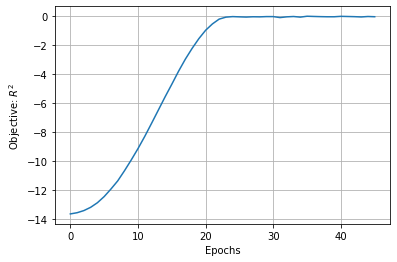

In [4]:
import matplotlib.pyplot as plt

point = {"lr": 0.01, "activation": "linear", "units": 10}
objective = run(point)
print("objective: ", objective)

plt.figure()
plt.plot(HISTORY["val_r2"])
plt.xlabel("Epochs")
plt.ylabel("Objective: $R^2$")
plt.grid()
plt.show()

## Defining the hyperparameter search space

The `run` function expects a hyperparameter dictionary with three keys: `units, activation, and lr`.
We will now define the acceptable ranges for these hyperparameters with the `Problem` object. Hyperparameter ranges are defined using the following syntax:

* Discrete integer ranges are generated from a tuple: `(lower: int, upper: int)`
* Continous parameters are generated from a tuple: `(lower: float, upper: float)`
* Categorical or nonordinal hyperparameters ranges can be given as a list of possible values: `[val1, val2, ...]`.

You probably have one or more "reference" sets of hyperparameters that are either hand-crafted or chosen by intuition. To bootstrap the search with these so-called `starting points`, use the `add_starting_point(...)` method.

<div class="alert alert-info">
    
<b>Tip</b>
    

Several starting points can be defined with `Problem.add_starting_point(**dims)`. All starting points will be evaluated before generating other evaluations.
    
</div>

    

In [5]:
from deephyper.problem import HpProblem

problem = HpProblem()

problem.add_hyperparameter((1, 100), "units")
problem.add_hyperparameter(["linear", "relu", "sigmoid", "tanh"], "activation")
problem.add_hyperparameter((0.0001, 1.0), "lr")

problem.add_starting_point(units=10, activation="linear", lr=0.01)

print(problem)

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {linear, relu, sigmoid, tanh}, Default: linear
    lr, Type: UniformFloat, Range: [0.0001, 1.0], Default: 0.50005
    units, Type: UniformInteger, Range: [1, 100], Default: 50


  Starting Point:
{0: {'activation': 'linear', 'lr': 0.01, 'units': 10}}


## Running the search

Create an `Evaluator` object using the `ray` backend to distribute the evaluation of the run-function defined previously.

In [6]:
from deephyper.evaluator.evaluate import Evaluator

evaluator = Evaluator.create(run, 
                 method="ray", 
                 method_kwargs={
                     "address": None, 
                     "num_cpus": 2,
                     "num_cpus_per_task": 1
                 })

print("Number of workers: ", evaluator.num_workers)

2021-09-16 11:48:10,875	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


Number of workers:  2


<div class="alert alert-info">
    
<b>Tip</b> 
    
You can open the ray-dashboard at an address like <a>http://127.0.0.1:8266</a> in a browser to monitor the CPU usage of the execution.
    
</div>

Finally, you can define a Bayesian optimization search called `AMBS` (for Asynchronous Model-Based Search) and link to it the defined `problem` and `evaluator`.

In [7]:
from deephyper.search.hps import AMBS

search = AMBS(problem, evaluator)

In [8]:
results = search.search(20)

(pid=95428) 2021-09-16 11:48:14.978728: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
(pid=95428) 2021-09-16 11:48:14.978957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=95428) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=95427) 2021-09-16 11:48:14.982031: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
(pid=95427) 2021-09-16 11:48:14.982255: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=95427) To enable them in other operations, rebuild TensorFlow with the 

(pid=95428) Epoch 00015: early stopping
(pid=95427) Epoch 00037: early stopping
(pid=95428) Epoch 00040: early stopping
(pid=95427) Epoch 00025: early stopping
(pid=95428) Epoch 00041: early stopping
(pid=95427) Epoch 00046: early stopping
(pid=95428) Epoch 00039: early stopping
(pid=95427) Epoch 00050: early stopping
(pid=95428) Epoch 00029: early stopping
(pid=95427) Epoch 00071: early stopping
(pid=95428) Epoch 00081: early stopping
(pid=95427) Epoch 00031: early stopping
(pid=95428) Epoch 00056: early stopping
(pid=95427) Epoch 00049: early stopping
(pid=95428) Epoch 00064: early stopping
(pid=95427) Epoch 00068: early stopping
(pid=95428) Epoch 00065: early stopping
(pid=95427) Epoch 00060: early stopping
(pid=95428) Epoch 00024: early stopping
(pid=95427) Epoch 00063: early stopping


Once the search is over, a file named `results.csv` is saved in the current directory. The same dataframe is returned by the `search.search(...)` call. It contains the hyperparameters configurations evaluated during the search and their corresponding `objective` value (i.e, validation accuracy), `duration` of computation and time of computation with `elapsed_sec`.

In [9]:
results

,activation,lr,units,id,objective,elapsed_sec,duration
0,relu,0.705605,54,2,0.689981,7.726394,4.705964
1,linear,0.010000,10,1,-0.058148,9.472755,6.452348
2,relu,0.538378,84,3,0.728182,11.619560,3.816638
3,relu,0.443972,24,4,0.730378,12.147245,2.531121
4,relu,0.241945,98,5,0.887672,15.860231,4.098998
5,relu,0.054648,5,6,0.246037,16.716952,4.427587
6,linear,0.290147,97,7,-0.147459,19.869695,3.768393
7,sigmoid,0.156309,99,8,-0.031136,21.559763,4.691238
8,relu,0.351568,98,9,0.777455,22.807760,2.805077
9,relu,0.234668,97,10,0.958552,27.922663,6.217307


The `deephyper-analytics` command line is a way of analyzing this type of file. For example, we want to output the best configuration we can use the `topk` functionnality.

In [10]:
!deephyper-analytics topk results.csv

(pid=95428) Epoch 00038: early stopping
'0':
  activation: relu
  duration: 5.3386099339
  elapsed_sec: 47.3330640793
  id: 18
  lr: 0.0280928241
  objective: 0.9766736031
  units: 73



## Testing the best configuration

(pid=95427) Epoch 00041: early stopping
Epoch 00080: early stopping
objective:  0.9653924703598022


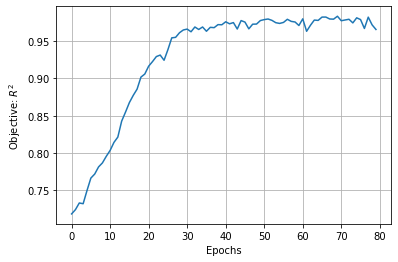

In [11]:
best_config = results.iloc[results.objective.argmax()][:-2].to_dict()
objective = run(best_config)
print("objective: ", objective)

plt.figure()
plt.plot(HISTORY["val_r2"])
plt.xlabel("Epochs")
plt.ylabel("Objective: $R^2$")
plt.grid()
plt.show()

Compared to the default configuration, we can see the accuracy improvement and the reduction of overfitting between the training and  the validation/test data sets.